In [5]:
# Basic libraries
import pandas as pd
import numpy as np
import joblib
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Load dataset
df = pd.read_csv('dataset/stack_overflow_2025_cleaned_eda.csv')
df.head()

,ResponseId,Age,Country,EdLevel,Employment,WorkExp,YearsCode,OrgSize,Industry,MainBranch,DevType,ICorPM,RemoteWork,LearnCode,LearnCodeChoose,LearnCodeAI,AIThreat,AISelect,AISent,AIOpen,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,DevEnvsHaveWorkedWith,ConvertedCompYearly,JobSat
0,1,25-34 years old,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,8.0,14.0,20 to 99 employees,Fintech,I am a developer by profession,"Developer, mobile",People manager,Remote,Online Courses or Certification (includes all ...,"Yes, I am not new to coding but am learning ne...","Yes, I learned how to use AI-enabled tools for...",I'm not sure,"Yes, I use AI tools monthly or infrequently",Indifferent,"Troubleshooting, profiling, debugging",Bash/Shell (all shells);Dart;SQL,Dart,Cloud Firestore;PostgreSQL,Amazon Web Services (AWS);Cloudflare;Firebase;...,Unknown,Android Studio;Notepad++;Visual Studio;Visual ...,61256.0,10.0
1,2,25-34 years old,Netherlands,"Associate degree (A.A., A.S., etc.)",Employed,2.0,10.0,500 to 999 employees,Retail and Consumer Services,I am a developer by profession,"Developer, back-end",Individual contributor,"Hybrid (some in-person, leans heavy to flexibi...",Online Courses or Certification (includes all ...,"Yes, I am not new to coding but am learning ne...","Yes, I learned how to use AI-enabled tools for...",I'm not sure,"Yes, I use AI tools weekly",Indifferent,All skills. AI is a flop.,Java,Java;Python;Swift,Dynamodb;MongoDB,Amazon Web Services (AWS);Datadog;Docker;Homeb...,Spring Boot,IntelliJ IDEA;PyCharm;Visual Studio Code;Xcode,104413.0,9.0
2,3,35-44 years old,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",10.0,12.0,Unknown,Software Development,I am a developer by profession,"Developer, front-end",Unknown,Unknown,Online Courses or Certification (includes all ...,"Yes, I am not new to coding but am learning ne...","Yes, I learned how to use AI-enabled tools for...",No,"Yes, I use AI tools daily",Favorable,"Understand how things actually work, problem s...",Dart;HTML/CSS;JavaScript;TypeScript,Dart;HTML/CSS;JavaScript;TypeScript,MongoDB;MySQL;PostgreSQL,Datadog;Firebase;npm;pnpm,Next.js;Node.js;React,Visual Studio Code,53061.0,8.0
3,4,35-44 years old,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,4.0,5.0,"10,000 or more employees",Retail and Consumer Services,I am a developer by profession,"Developer, back-end",Individual contributor,Remote,"Other online resources (e.g. standard search, ...","Yes, I am not new to coding but am learning ne...","Yes, I learned how to use AI-enabled tools for...",No,"Yes, I use AI tools weekly",Favorable,Unknown,Java;Kotlin;SQL,Java;Kotlin,Unknown,Amazon Web Services (AWS);Google Cloud,Spring Boot,Unknown,36197.0,6.0
4,5,35-44 years old,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",21.0,22.0,Unknown,Software Development,I am a developer by profession,Engineering manager,Unknown,Unknown,Unknown,"No, I am not new to coding and did not learn n...","Yes, I learned how to use AI-enabled tools for...",No,"Yes, I use AI tools weekly",Favorable,"critical thinking, the skill to define the tas...",C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...,C#;Java;JavaScript;Python;SQL;TypeScript,Elasticsearch;Microsoft SQL Server;MySQL;Oracl...,Amazon Web Services (AWS);APT;Docker;Make;Mave...,Angular;ASP.NET;ASP.NET Core;Flask;jQuery,Eclipse;IntelliJ IDEA;Jupyter Notebook/Jupyter...,60000.0,7.0


### Selecting features for the model

In [14]:
num_features = ['WorkExp', 'YearsCode', 'JobSat']

ordinal_features = ['Age', 'EdLevel', 'OrgSize']

nominal_features = ['Country', 'Industry', 'RemoteWork', 'DevType']


### Preparing ordinal features

In [15]:
from sklearn.preprocessing import OrdinalEncoder

age_order = [
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older',
    'Prefer not to say'
]

edlevel_order = [
    'Primary/elementary school',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
    'Associate degree (A.A., A.S., etc.)',
    'Some college/university study without earning a degree',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
    'Other (please specify):',
    'Unknown'
]

orgsize_order = [
    'Just me - I am a freelancer, sole proprietor, etc.',
    'Less than 20 employees',
    '20 to 99 employees',
    '100 to 499 employees',
    '500 to 999 employees',
    '1,000 to 4,999 employees',
    '5,000 to 9,999 employees',
    '10,000 or more employees',
    'I don’t know',
    'Unknown'
]


### Standardizing numerical features and encoding categorical features

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('ord', OrdinalEncoder(
            categories=[age_order, edlevel_order, orgsize_order],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), ordinal_features),
        ('nom', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False
        ), nominal_features)
    ]
)


### Making pipeline for preprocessing and model implementation

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])


### Droping missing salary rows 

In [18]:
df_model = df.dropna(subset=['ConvertedCompYearly']).copy()

X = df_model[num_features + ordinal_features + nominal_features]
y = df_model['ConvertedCompYearly']


### Train test split

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


### Log transform the salaries and fitting the pipeline

In [20]:
from sklearn.compose import TransformedTargetRegressor
import numpy as np

model = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

model.fit(X_train, y_train)


C:\Users\abdul\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\numeric.py:2457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


,regressor,Pipeline(step...m_state=42))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('num', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


### Error Metrics


In [21]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"R² Score: {r2:.3f}")


MAE: 45,462.15
R² Score: 0.020


## Only training on numerical features

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge


In [7]:
# Numeric features
num_features = ['WorkExp', 'YearsCode', 'JobSat']

### Removing missing values and outliers

In [8]:
# Drop rows with missing target or numeric features
df_model = df.dropna(subset=['ConvertedCompYearly'] + num_features).copy()

# Remove extreme salary outliers
df_model = df_model[df_model['ConvertedCompYearly'].between(1000, 300000)]

### Standardization

In [9]:

# Define X and y
X = df_model[num_features]
y = df_model['ConvertedCompYearly']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


### Training the models

In [10]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    'Ridge': Ridge(alpha=1.0)
}

# Train models and store predictions
predictions = {}
metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    predictions[name] = y_pred
    metrics[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }




### Error Metrics

In [11]:
# Display metrics
for name, m in metrics.items():
    print(f"{name} -> MAE: {m['MAE']:,.2f}, R²: {m['R2']:.3f}")

RandomForest -> MAE: 44,231.34, R²: 0.087
GradientBoosting -> MAE: 41,352.36, R²: 0.203
Ridge -> MAE: 43,150.86, R²: 0.146


### Residual Plot

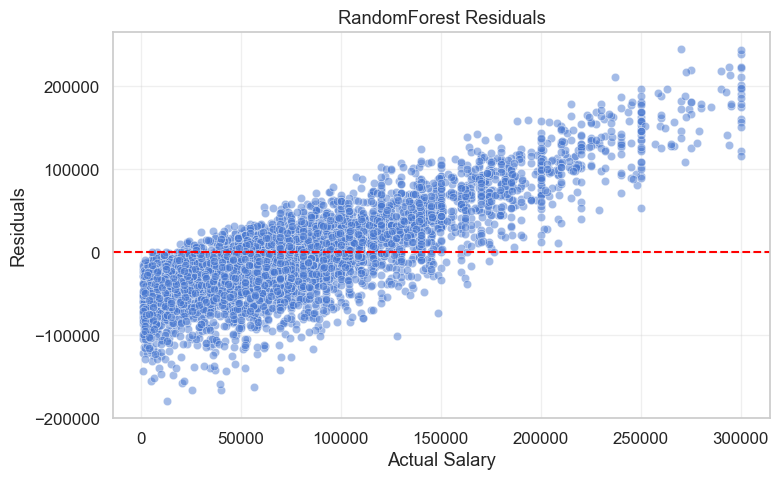

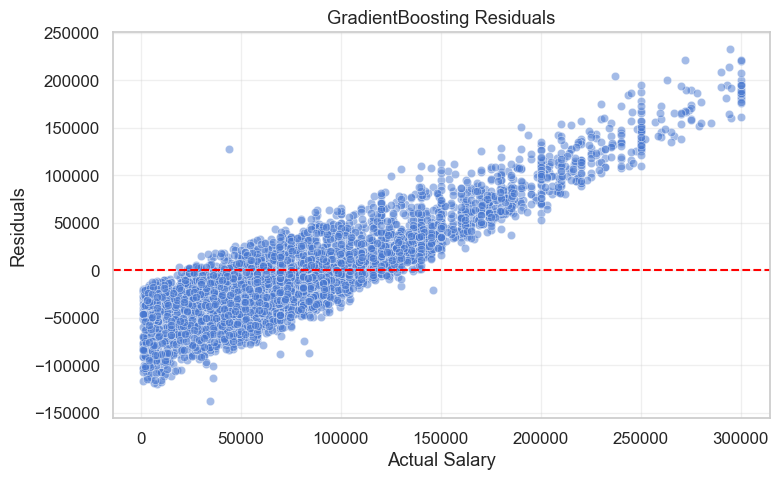

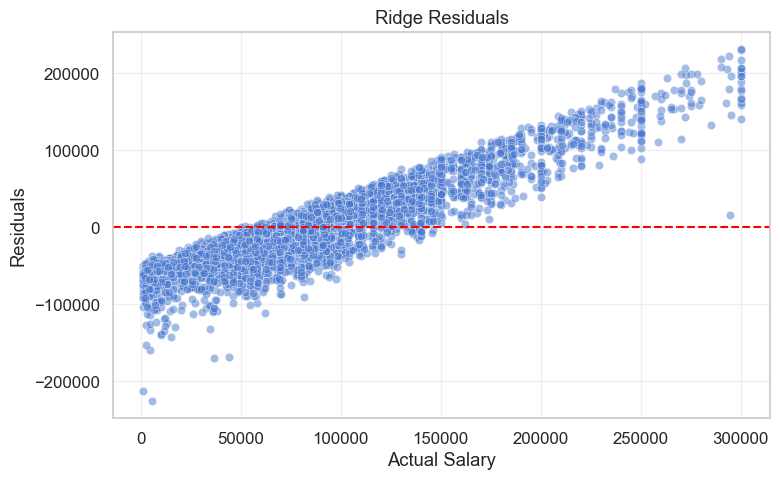

In [12]:
for name, y_pred in predictions.items():
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_test, y=y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Actual Salary')
    plt.ylabel('Residuals')
    plt.title(f'{name} Residuals')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{name}_residuals.png')
    plt.show()


### Actual vs Predicted plot

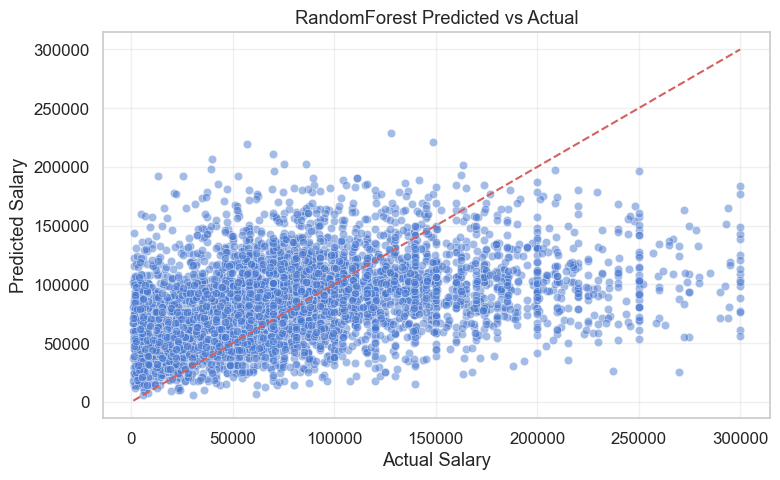

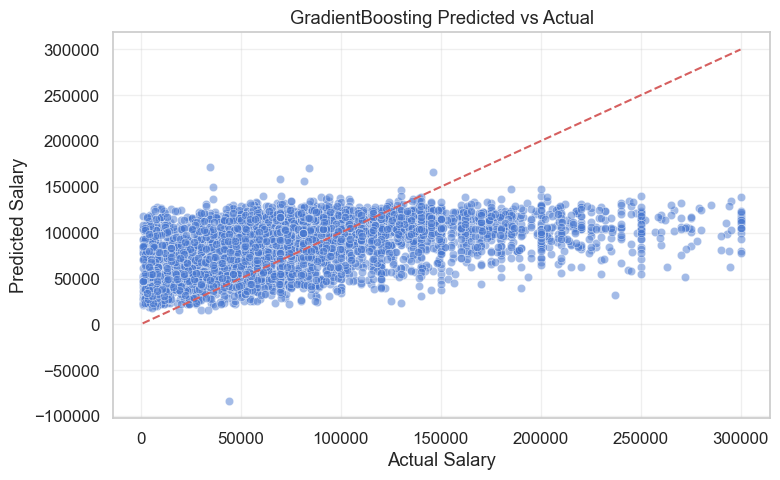

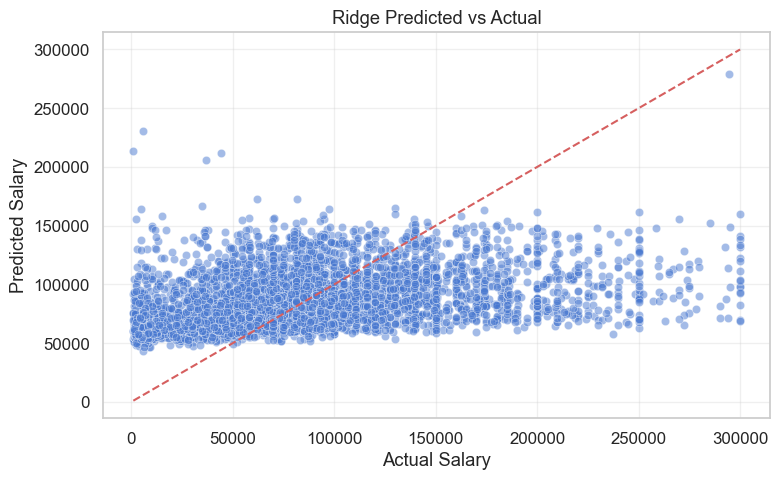

In [13]:
for name, y_pred in predictions.items():
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Salary')
    plt.ylabel('Predicted Salary')
    plt.title(f'{name} Predicted vs Actual')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{name}_predicted_vs_actual.png')
    plt.show()


### Feature Importance

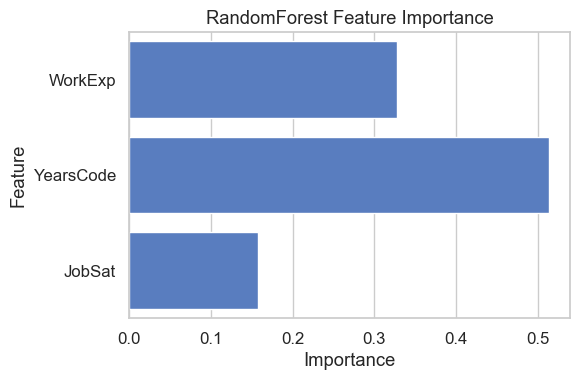

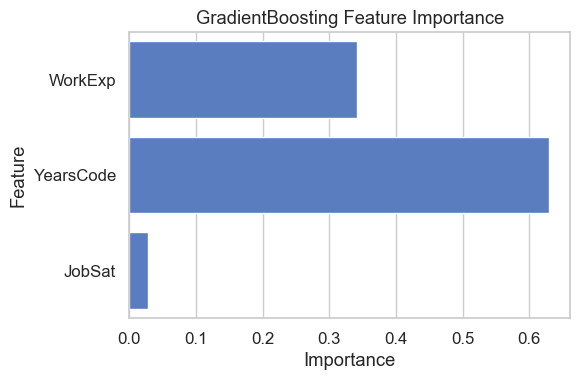

In [14]:
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        plt.figure(figsize=(6,4))
        sns.barplot(x=importance, y=num_features)
        plt.title(f'{name} Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig(f'{name}_feature_importance.png')
        plt.show()


In [15]:
for name, model in models.items():
    joblib.dump(model, f'{name}_model.pkl')
print("All models saved for web app!")


All models saved for web app!
